# Scraping Notícias

In [ ]:
# Instalar biblioteca
!pip install cloudscraper

In [ ]:
# Importar bibliotecas
import cloudscraper
import re
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
# Carregar base com as urls
urls = pd.read_excel('/content/urls.xlsx', sheet_name ='holanda(Manaus)')

In [ ]:
# Realizar em máquina local, tendo em vista que o scraping não funciona no Colab
scraper = cloudscraper.create_scraper(delay=10,   browser={'custom': 'ScraperBot/1.0',})

linkMateria = []
tituloMateria = []
corpoMateria = [] 

for url in urls.url:
    try:

        req = scraper.get(url)
        if req.status_code == 200 or 403:
            soup = BeautifulSoup(req.content, "html.parser")
            link = url
            titulo = soup.find('h1',class_="noticia titulo").text
            
            for div in soup.select('[class="corpo corpo1"]'):
                p = div.find_all('p')
            corpoMateria.append(p)
        
            linkMateria.append(link)
            tituloMateria.append(titulo)

    except:
        pass

In [ ]:
# Converter para df
df = pd.DataFrame(list(zip(linkMateria,tituloMateria, corpoMateria)), columns=['link','titulo', 'materia'])
df.head(3)

,link,titulo,materia


# Mineração de texto

In [1]:
# Importar bibliotecas
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [2]:
# Ler base
df = pd.read_excel('/content/holanda.xlsx')

# Remover duplicados
df = df.drop_duplicates(subset=['link'], keep='first')

In [3]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/manausStopwords.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [5]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

### Funções

In [6]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transformar em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(mode = "RGBA", background_color=None,width=800, height=400, max_words=50).generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

### Pré-processamento

In [7]:
df['materiaLimpa'] = df.materia.apply(parser)
df['tituloLimpo'] = df.titulo.apply(parser)

df['tituloLimpo'] = limparTitulos(df['tituloLimpo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

## Tokenização e frequências

In [8]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

In [9]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(50) 

,Termos,Frequência
3,espancado,24
5,suspeito,22
4,populares,18
13,homem,18
18,assalto,16
12,surra,8
82,assaltar,6
6,estuprar,5
21,leva,5
8,vizinhos,5


In [10]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(50)

,Termos,Frequência
0,homem,76
20,policia,67
80,suspeito,58
11,zona,48
17,populares,46
9,bairro,45
28,rua,35
158,vitima,34
58,hospital,31
14,espancado,30


## Nuvem de palavras

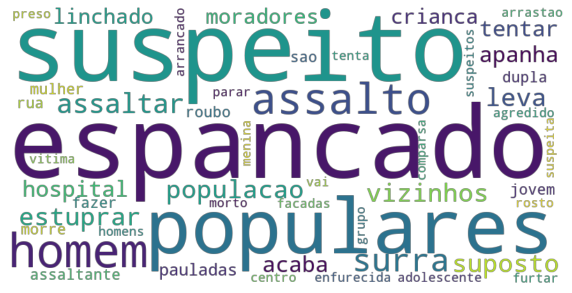

In [ ]:
gerarNuvem(frequenciaTitulo)

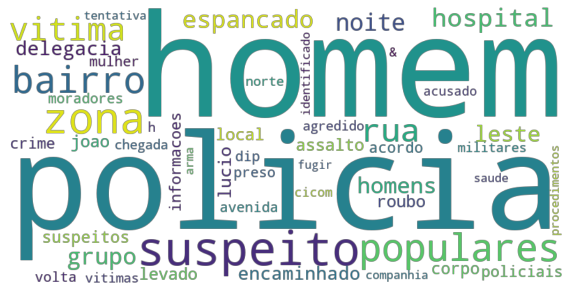

In [ ]:
gerarNuvem(frequenciaMateria)